# Problem statement

The UC Irvine machine learning data repository hosts a collection of data on adult income, donated by Ronny Kohavi and Barry Becker. You can find this data at https://archive.ics.uci.edu/ml/datasets/Adult For each record, there is a set of continuous attributes, and a class "less than 50K" or "greater than 50K". We have pre-split the data training with 43957 examples with known class labels, and testing data with 4885 examples without class labels. Use this data, not the original, for this assignment.

Write a program to train a support vector machine on this data using stochastic gradient descent.

You should not use a package to train the classifier, but your own code. You should ignore the id number, and use only the continuous variables as a feature vector. You should scale these variables so that each has unit variance, and you should subtract the mean so that each has zero mean. You should search for an appropriate value of the regularization constant, trying at least the values [1e-3, 1e-2, 1e-1, 1]. Use 10% of your training data as a validation set for this search. You should use at least 50 epochs seasons of at least 300 steps each. In each epoch season, you should separate out 50 training examples at random for evaluation (call this the set held out for the epoch season). You should compute the accuracy of the current classifier on the validation set for the epoch season every 30 steps.

You should produce:

A plot of the validation accuracy every 30 steps, for each value of the regularization constant.
A plot of the magnitude of the coefficient vector every 30 steps, for each value of the regularization constant.
Your estimate of the best value of the regularization constant, together with a brief description of why you believe that is a good value.
Answer the question: What was your choice for the learning rate and why did you choose it?
Once you have trained your final classifier, score the provided test set, recording the results in a file with the same format as submission.txt.  

Lambda_accuracies: [[1e-05, 0.7968607825295724], [0.0001, 0.8111919927206551], [0.001, 0.8105095541401274], [0.01, 0.7977707006369427], [0.1, 0.802547770700637], [1, 0.7670609645131938]]


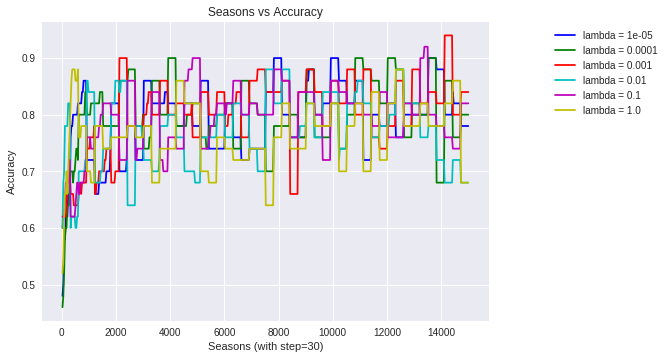

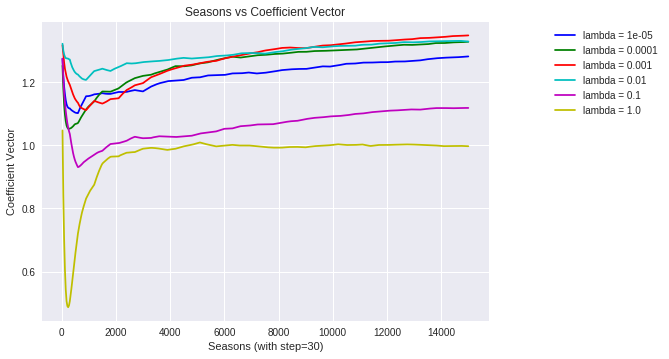

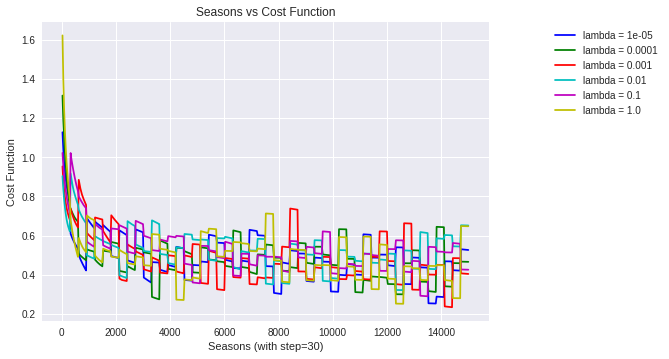

In [36]:
#Sayantan Dutta

#Cost Function
def cost_function(u, lambdaa, data):
    count = 0
    a = u[:-1]
    b = u[-1]
    error_sum = 0
    N = len(data)
    penalty_term = 1/2 * np.asscalar(np.transpose(a).dot(a))
    for record in data:
        count += 1
        features = np.array(record[:-1])
        label = record[-1]
        gamma = calculate_gamma(u, features)
        error = 1 - (label * gamma)
        error_sum += max(0, np.asscalar(error))
    cost = (1/N * error_sum) + (lambdaa * penalty_term)
    return cost

#calculate gamma # gamma = a*x+b (x--> features)
def calculate_gamma(u, features):
    a = u[:-1]
    b = u[-1]
    gamma = np.transpose(a).dot(features) + b
    return gamma

#Evaluate Model Accuracy
def evaluate_model_accuracy(u, lambdaa, data):
    correct_count = 0 
    for record in data:
        features = np.array(record[:-1])        
        label = record[-1]   
        gamma = calculate_gamma(u, features)
        prediction = np.sign(gamma)        
        if prediction == label:
            correct_count += 1
    return float(correct_count/len(data))
        


#Calculate Stochastic Gradient Descent
def retrieve_sgd(u_initial, lambdaa, data):
    features = np.array(data[:-1])
    label = data[-1]
    gamma = calculate_gamma(u_initial, features)
    term = label * gamma
    a = u_initial[:-1]
    b = u_initial[-1] 
    a_delta = np.array([])
    b_delta = 0
    
    #if gamma and label has same sign, i.e gamma (predicted label) has correctly identified actual label
    # a_delta = lamdaa * a ; b_delta = 0
    if term >= 1:
        a_delta = lambdaa * a
        b_delta = 0
        
    #if gamma and label has opposite sign, i.e gamma (predicted label) has incorrectly identified actual label
    # a_delta = (lamdaa * a) - (label * features) ; b_delta = -label
    else:
        a_delta = np.subtract(lambdaa * a, (label * features).reshape(6,1))
        b_delta = -label
    
    sgd = (np.append(np.array(a_delta), np.array([b_delta]))).reshape(7,1)
    return sgd


def train_svm_model(u_initial, lambdaa, train_data_internal, log_lambda=False):
    seasons = 50
    total_steps = 300    
    data_size_per_season = 50    
    counter = 1
    cost_total = []
    lambda_log_dict = {}
    
    if log_lambda:        
        lambda_log_dict[lambdaa] = []
        
    for i in range(seasons):       
        np.random.shuffle(train_data_internal)
        # data held for this season
        data_for_this_season =  train_data_internal[:data_size_per_season]
        for j in range(total_steps):
            #Calculate Stochastic Gradient Descent
            sgd = retrieve_sgd(u_initial, lambdaa,data_for_this_season[0])            
            for x in range(0,data_size_per_season):
                sgd += retrieve_sgd(u_initial, lambdaa, data_for_this_season[x])                
            sgd /=  data_size_per_season
            step = learning_rate(counter) * sgd
            u_initial = np.subtract(u_initial, step)
            counter += 1
            
            #for every 30 step log lambda values
            if (counter % 30 == 0 and log_lambda):
                accuracy = evaluate_model_accuracy(u_initial, lambdaa, data_for_this_season)
                norm_u = np.linalg.norm(u_initial)
                # Calculate current cost
                cost = cost_function(u_initial, lambdaa, data_for_this_season)
                lambda_log_dict[lambdaa].append([counter, accuracy, norm_u, cost])
                
    return u_initial, cost_total, lambda_log_dict


def learning_rate(season):
    return 1 / (season + 100)

def retrieve_accuracy_of_lambdas(list_of_lambdas, train_data):
    #print('retrieving accuracy of lambdas..') ####
    u_initial = np.random.rand(7,1)
    lambda_accuracies = [0 for i in range(0, len(list_of_lambdas))]
    All_lambda_log_dict = {}
        
    Ntrain = int(np.shape(train_data)[0] * 0.9)
    for j in range(len(list_of_lambdas)): 
        #print(f'Calculating for lambda: {list_of_lambdas[j]}') ####
        lambdaa =  list_of_lambdas[j]
        #Splitting data for 90% training, 10% validation   
        np.random.shuffle(train_data)
        train_data_internal =  train_data[:Ntrain]
        validation_set = train_data[Ntrain:]
        u_copy = np.copy(u_initial)
        model_output = train_svm_model(u_copy, lambdaa, train_data_internal, log_lambda=True)
        u_optimum = model_output[0]
        lambda_log_dict = model_output[2]
        accuracy = evaluate_model_accuracy(u_optimum, lambdaa, validation_set)
        lambda_accuracies[j] += accuracy                
        All_lambda_log_dict[lambdaa] = lambda_log_dict[lambdaa]
     
    return lambda_accuracies, All_lambda_log_dict
  
def Main_model_eval(lambdaa, train_data, test_data):
    u_initial = np.random.rand(7,1)
    model_output = train_svm_model(u_initial, lambdaa, train_data)
    u_optimized = model_output[0]
    submission = open("submission.csv", "a+")
    for i in range(0, len(test_data)):
        features = np.array(test_data[i]).reshape(6,1)
        prediction = calculate_gamma(u_optimized, features)
        if prediction > 0:
            # >50K
            submission.write(">50K")
            submission.write("\n")
        else:
            #" <=50K"
            submission.write("<=50K")
            submission.write("\n")
    submission.close()
    
def get_list(All_lambda_log_dict):
  df_e5 = pd.DataFrame(All_lambda_log_dict[1e-5])
  df_e4 = pd.DataFrame(All_lambda_log_dict[1e-4])
  df_e3 = pd.DataFrame(All_lambda_log_dict[1e-3])
  df_e2 = pd.DataFrame(All_lambda_log_dict[1e-2])
  df_e1 = pd.DataFrame(All_lambda_log_dict[1e-1])
  df_e0 = pd.DataFrame(All_lambda_log_dict[1e-0])
  list_df = [df_e5, df_e4, df_e3, df_e2, df_e1, df_e0]
  return list_df
    
def lambda_accuracy_graph(All_lambda_log_dict):
  list_df = get_list(All_lambda_log_dict)
  
  plt.title('Seasons vs Accuracy')
  plt.xlabel('Seasons (with step=30)')
  plt.ylabel('Accuracy')
  for i in range(6):
    colors = ['b','g','r','c','m','y']
    lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]
    x=np.array(list_df[i][0])
    y=list_df[i][1]
    label = 'lambda = ' + str(lambdas[i])
    plt.plot(x, y, colors[i], label = label)
    plt.legend(loc='best', bbox_to_anchor=(0.9, 0.5, 0.5, 0.5))
  plt.show()  
  
def lambda_coefficient_graph(All_lambda_log_dict):
  list_df = get_list(All_lambda_log_dict)
  
  plt.title('Seasons vs Coefficient Vector')
  plt.xlabel('Seasons (with step=30)')
  plt.ylabel('Coefficient Vector')
  for i in range(6):
    colors = ['b','g','r','c','m','y']
    lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]
    x=np.array(list_df[i][0])
    y=list_df[i][2]
    label = 'lambda = ' + str(lambdas[i])
    plt.plot(x, y, colors[i], label = label)
    plt.legend(loc='best', bbox_to_anchor=(0.9, 0.5, 0.5, 0.5))
  plt.show()
  
def cost_function_graph(All_lambda_log_dict):
  list_df = get_list(All_lambda_log_dict)
  
  plt.title('Seasons vs Cost Function')
  plt.xlabel('Seasons (with step=30)')
  plt.ylabel('Cost Function')
  for i in range(6):
    colors = ['b','g','r','c','m','y']
    lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]
    x=np.array(list_df[i][0])
    y=list_df[i][3]
    label = 'lambda = ' + str(lambdas[i])
    plt.plot(x, y, colors[i], label = label)
    plt.legend(loc='best', bbox_to_anchor=(0.9, 0.5, 0.5, 0.5))
  plt.show()
      
    
#Program starts here 
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# retrieve pre-processed scaled data    
df = pd.read_csv('scaled_train_and_label_data.csv', header=None, dtype=np.float64)
train_data = df.as_matrix()
df1= pd.read_csv('scaled_test_data.csv', header=None, dtype=np.float64)
test_data = df1.as_matrix()

#List of lambda values to work on
list_of_lambdas = [1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]
#Find accuracy for each lambda value
accuracies, All_lambda_log_dict = retrieve_accuracy_of_lambdas(list_of_lambdas, train_data)
lambda_accuracies = [list(x) for x in zip(list_of_lambdas, accuracies )]
print(f'Lambda_accuracies: {lambda_accuracies}')
lambda_accuracy_graph(All_lambda_log_dict)
lambda_coefficient_graph(All_lambda_log_dict)
cost_function_graph(All_lambda_log_dict)

#lambdaa = 1e-4
#Main_model_eval(lambdaa, train_data, test_data)


In [0]:
lambdaa = 1e-4
Main_model_eval(lambdaa, train_data, test_data)